## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# How to Properly Prevent Overfitting

🎯 **Goals of this challenge**
- **`Cross Validate`** a Deep Learning Model
- Give a **`Validation Set`** to the model
- Apply two techniques to prevent overfitting:
    - Use the **`Early Stopping`** criterion to prevent the Neural network from over-learning / over-fitting
    - **`Regularize`** your network
- Analyze the **`impact of the batch size and the number of epochs`** on the training of a Neural Network

## Data - the `blobs` Dataset

### Generating a Blobs Dataset

First, let's generate some data using the [`make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function from Scikit-Learn

Generate 2000 samples with 10 features each; there should be 8 classes of blobs (`centers` argument) with `cluster_std` equal to 7.

In [2]:
X, y = make_blobs(
    n_samples=2000,
    n_features=10,
    centers=8,
    cluster_std=7,
    random_state=42
)

### Visualizing the Dataset

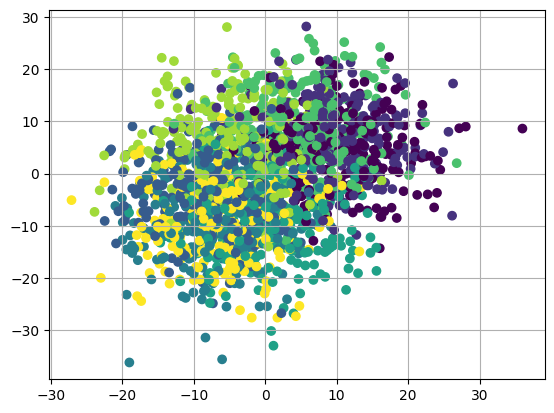

In [3]:
plt.grid(True)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap='viridis');

### Encoding your Categorical Target

In [4]:
y_cat = to_categorical(y, num_classes=8)
y_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
y

array([5, 3, 1, ..., 2, 7, 4])

## (1) Cross-Validation in Deep Learning

### Designing a Neural Network

First, write a function that generates a Neural Network with 3 layers:

<u>Architecture</u>
- an **input layer** with 25 neurons, the `relu` activation function and the appropriate `input_dim`
- a **hidden layer** with 10 neurons and the `relu` activation function.
- a **predictive layer** that is suited to the problem at hand (*multiclass classification*)

<u>Compilation</u>

The function should include a compilation method with:
- the *categorical_crossentropy* loss
- the *Adam* optimizer 
- the *accuracy* metric

In [6]:
def initialize_model():
    
    model = models.Sequential()
    model.add(layers.Dense(25, activation='relu', input_dim=10))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(8,activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Cross-Validating the Neural Net

🧑🏻‍💻 Write a _loop_ using the [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from Scikit-Learn.

* ✂️ Choose 10 splits to fit your model on the training data
* 🧪 Evaluate your model on the testing data, and store the results of the evaluation into a `results` variable.

In [7]:
%%time
results = []
kf = KFold(n_splits=10)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    # Split the data into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]
    
    # Scaling your data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    # Initialize the model
    model = initialize_model()

    # Fit the model on the train data
    model.fit(
        X_train_scaled,
        y_train,
        epochs=150,
        batch_size=16,
        verbose=0
    )
    # Evaluate the model on the test data
    results.append(model.evaluate(X_test_scaled, y_test, verbose=0))





CPU times: total: 11min 8s
Wall time: 6min 25s


### Performance of the Cross-Validated Network

Print the average accuracy of these 10 folds and the standard deviation of these 10 accuracy values.

In [8]:
accuracy = [_[1] for _ in results]
print(f'New mean accuracy: {np.mean(accuracy)*100:.2f}% (±{np.std(accuracy)*100:.2f})')

New mean accuracy: 77.65% (±2.81)


### Holdout Method

For the rest of the exercise (and of the Deep Learning module), split the dataset into a training set and a testing set with a 70/30% training-to-test data ratio.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 10), (600, 10), (1400, 8), (600, 8))

In [10]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## (2) How to Prevent a Neural Network from Overfitting?

### (2.1) Early Stopping

In [11]:
%%time
model = initialize_model()
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=500,
    validation_split=0.3,
    verbose=0,
    shuffle=True,
    batch_size=16
)

CPU times: total: 3min 21s
Wall time: 2min 9s


#### Your Neural Network's Performance

Evaluate the model on the testing set and print the accuracy.

In [12]:
result = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'The accuracy on the test set is of {result[1]:.2f}')

The accuracy on the test set is of 0.76


#### Learnings About Number of Epochs

Plot the history of the model with the `plot_loss_accuracy()` function that we coded for you.

In [13]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis='x',linewidth=0.5)
    ax[0].grid(axis='y',linewidth=0.5)

    # --- ACCURACY
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis='x', linewidth=0.5)
    ax[1].grid(axis='y', linewidth=0.5)

    if title:
        fig.suptitle(title)

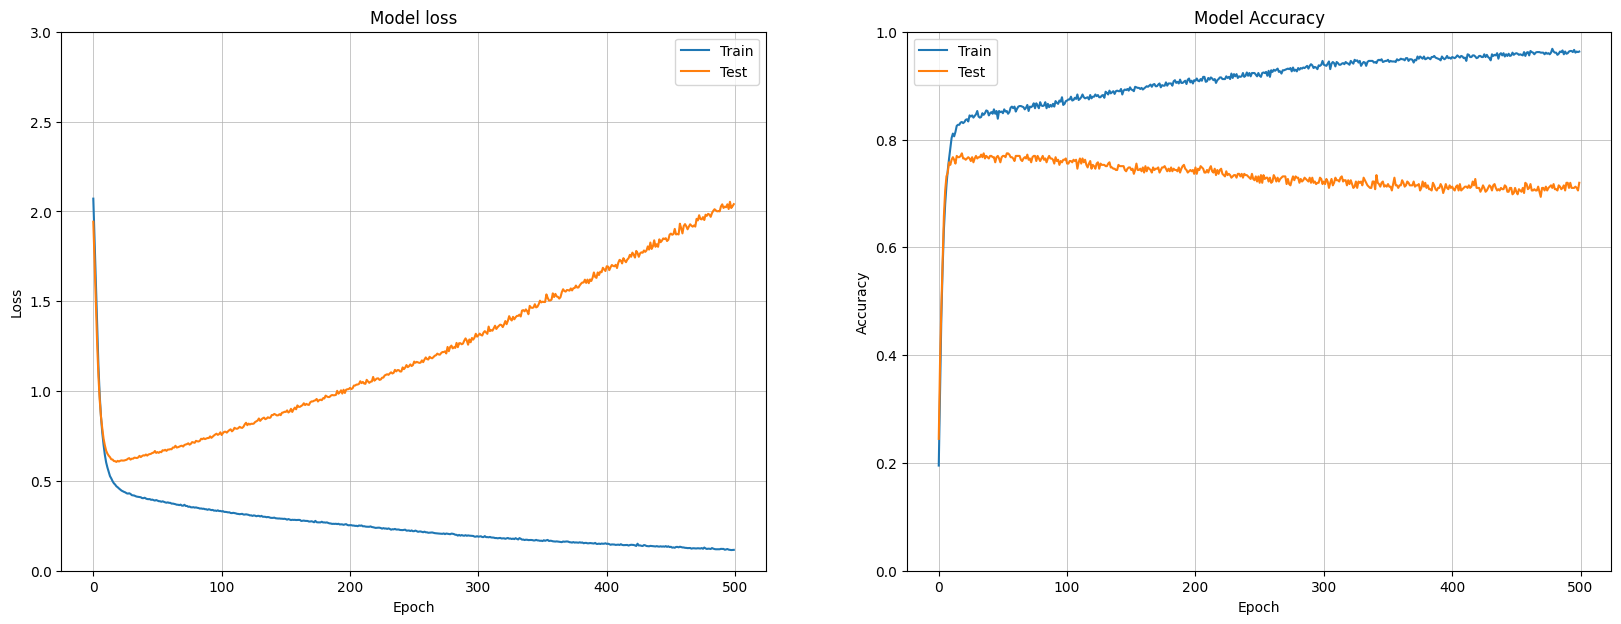

In [14]:
plot_loss_accuracy(history)

##### Observing the Early Stopping Criterion

In [15]:
%%time
es = EarlyStopping()
model = initialize_model()
# Fit the model on the train data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

Epoch 1/500
62/62 [==============================] - 3s 12ms/step - loss: 2.0110 - accuracy: 0.2104 - val_loss: 1.9271 - val_accuracy: 0.2328
Epoch 2/500
62/62 [==============================] - 0s 4ms/step - loss: 1.7669 - accuracy: 0.3871 - val_loss: 1.6854 - val_accuracy: 0.4299
Epoch 3/500
62/62 [==============================] - 0s 5ms/step - loss: 1.5174 - accuracy: 0.5260 - val_loss: 1.4669 - val_accuracy: 0.5368
Epoch 4/500
62/62 [==============================] - 0s 5ms/step - loss: 1.3067 - accuracy: 0.6057 - val_loss: 1.2940 - val_accuracy: 0.5677
Epoch 5/500
62/62 [==============================] - 0s 5ms/step - loss: 1.1390 - accuracy: 0.6517 - val_loss: 1.1554 - val_accuracy: 0.5843
Epoch 6/500
62/62 [==============================] - 0s 5ms/step - loss: 1.0021 - accuracy: 0.6864 - val_loss: 1.0402 - val_accuracy: 0.6485
Epoch 7/500
62/62 [==============================] - 0s 4ms/step - loss: 0.8927 - accuracy: 0.7191 - val_loss: 0.9472 - val_accuracy: 0.6865
Epoch 8/500


##### Evaluate the ES Model

The accuracy on the test set is of 0.78


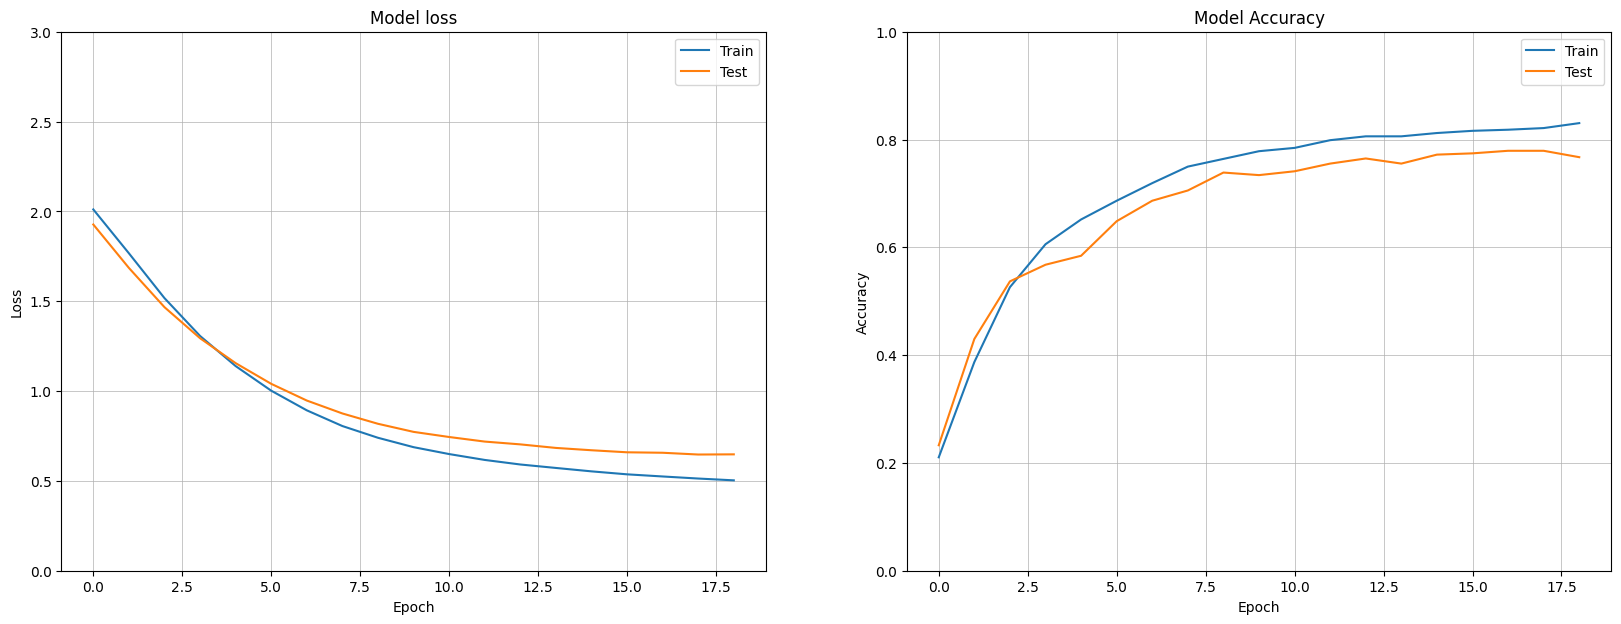

In [16]:
plot_loss_accuracy(history)
results = model.evaluate(X_test_scaled, y_test, verbose = 0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

Use the `EarlyStopping` criterion with a patience term of 30 epochs, plot the results, and print the accuracy on the testing set

The accuracy on the test set is of 0.78
CPU times: total: 22.4 s
Wall time: 15 s


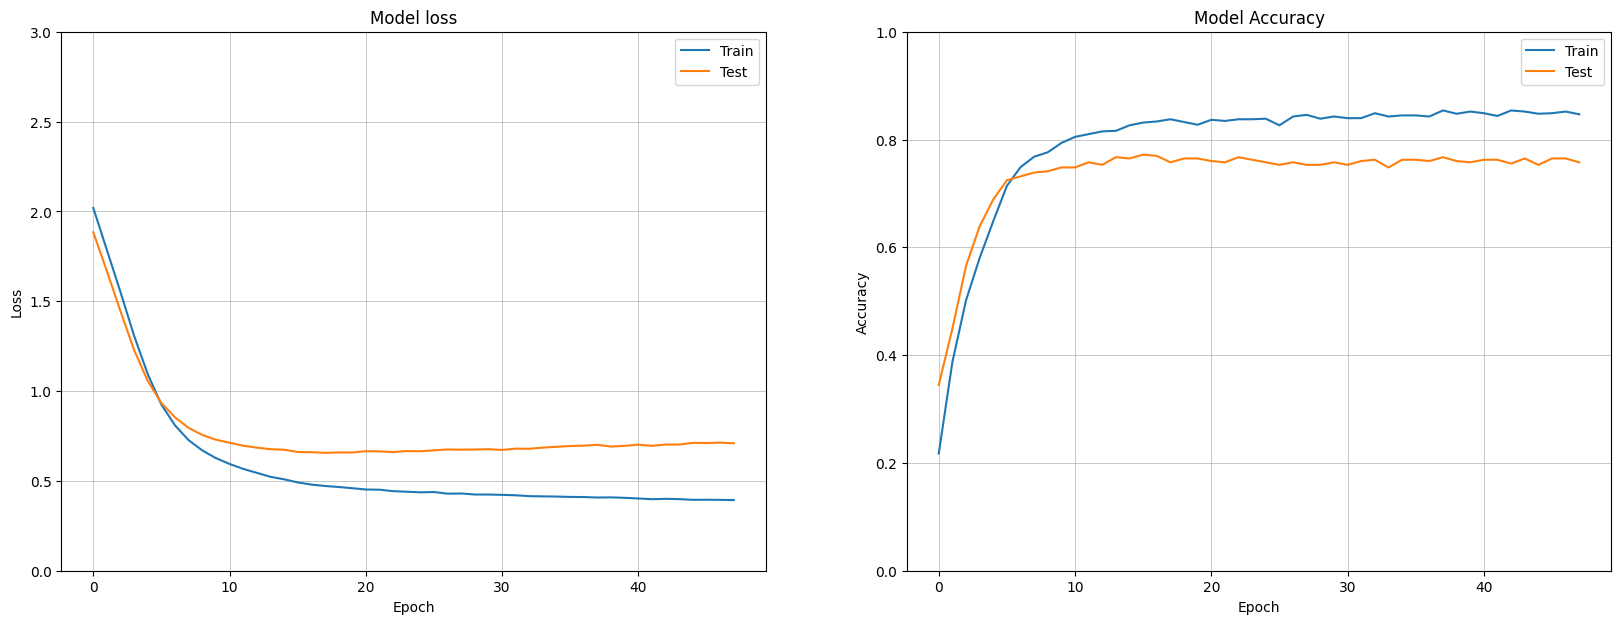

In [17]:
%%time
es = EarlyStopping(patience=30)
model = initialize_model()
# Fit the model on the train data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 0, 
    callbacks = [es]
)
# Observing the loss and the metrics w.r.t. epochs
plot_loss_accuracy(history)
# Evaluating the model on the testing set
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

##### Restoring the Best Weights of a Model

- Run the model with an Early Stopping criterion that will restore the best weights of the Neural Net
- Plot the loss and accuracy 
- Print the accuracy on the testing set

The accuracy on the test set is of 0.77
CPU times: total: 23.2 s
Wall time: 15.1 s


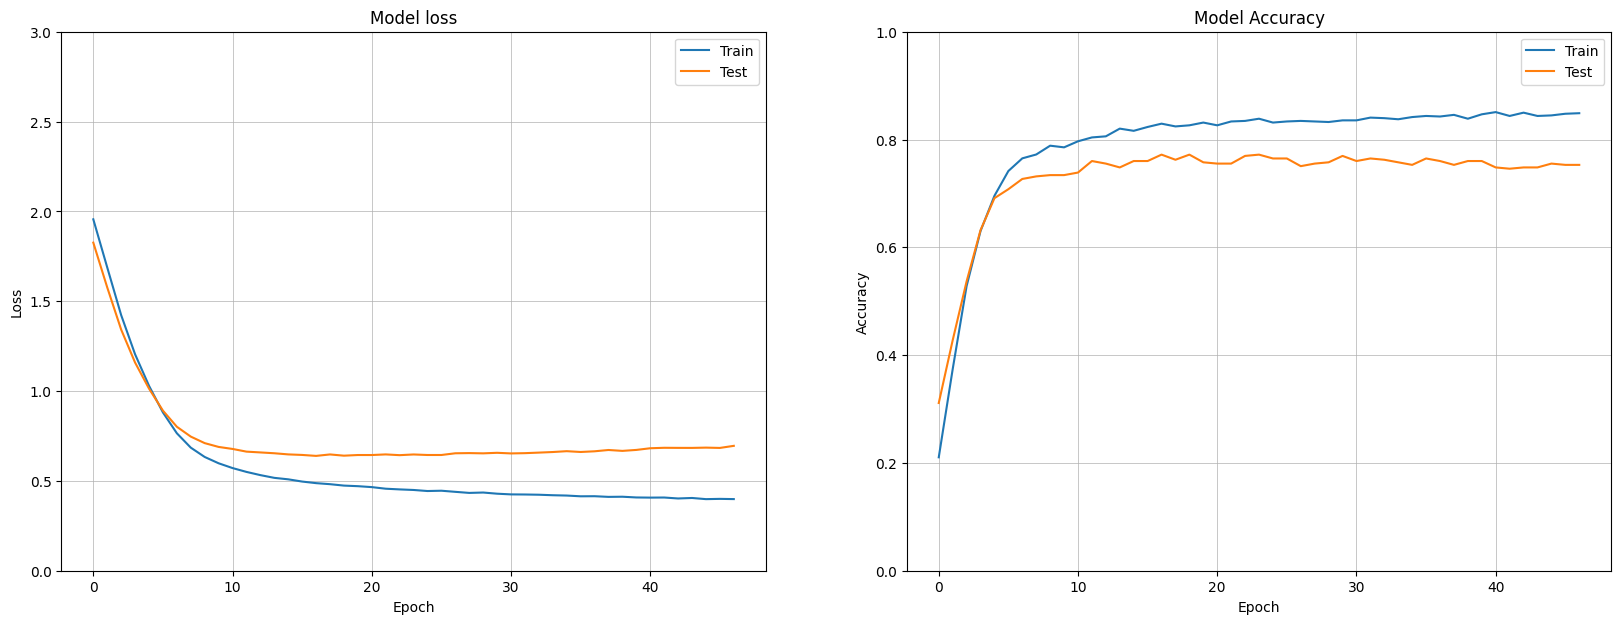

In [18]:
%%time
es = EarlyStopping(patience=30, restore_best_weights=True)
model = initialize_model()
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 0, 
    callbacks = [es]
)
plot_loss_accuracy(history)
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

### (2.2) Batch Size & Epochs

#### Playing with the Batch Size

CPU times: total: 3min
Wall time: 2min 1s


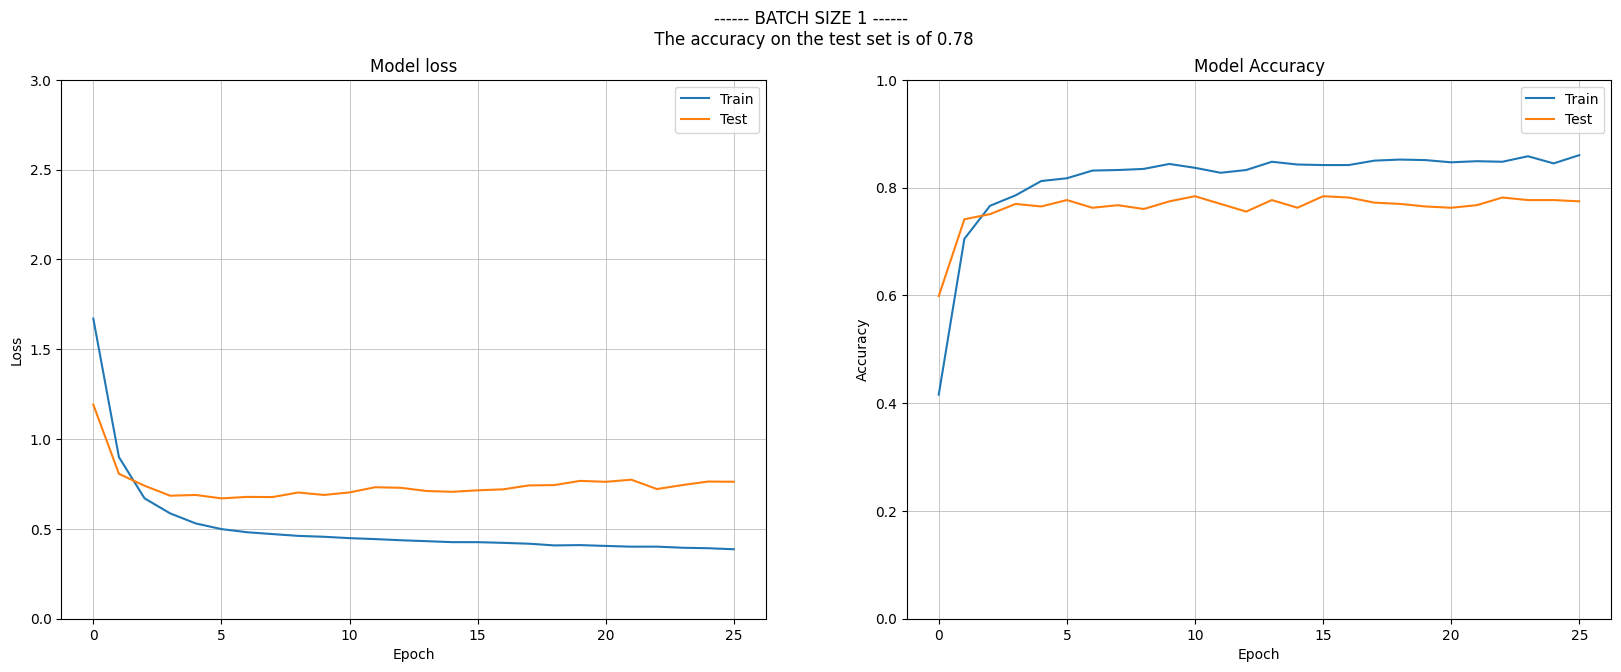

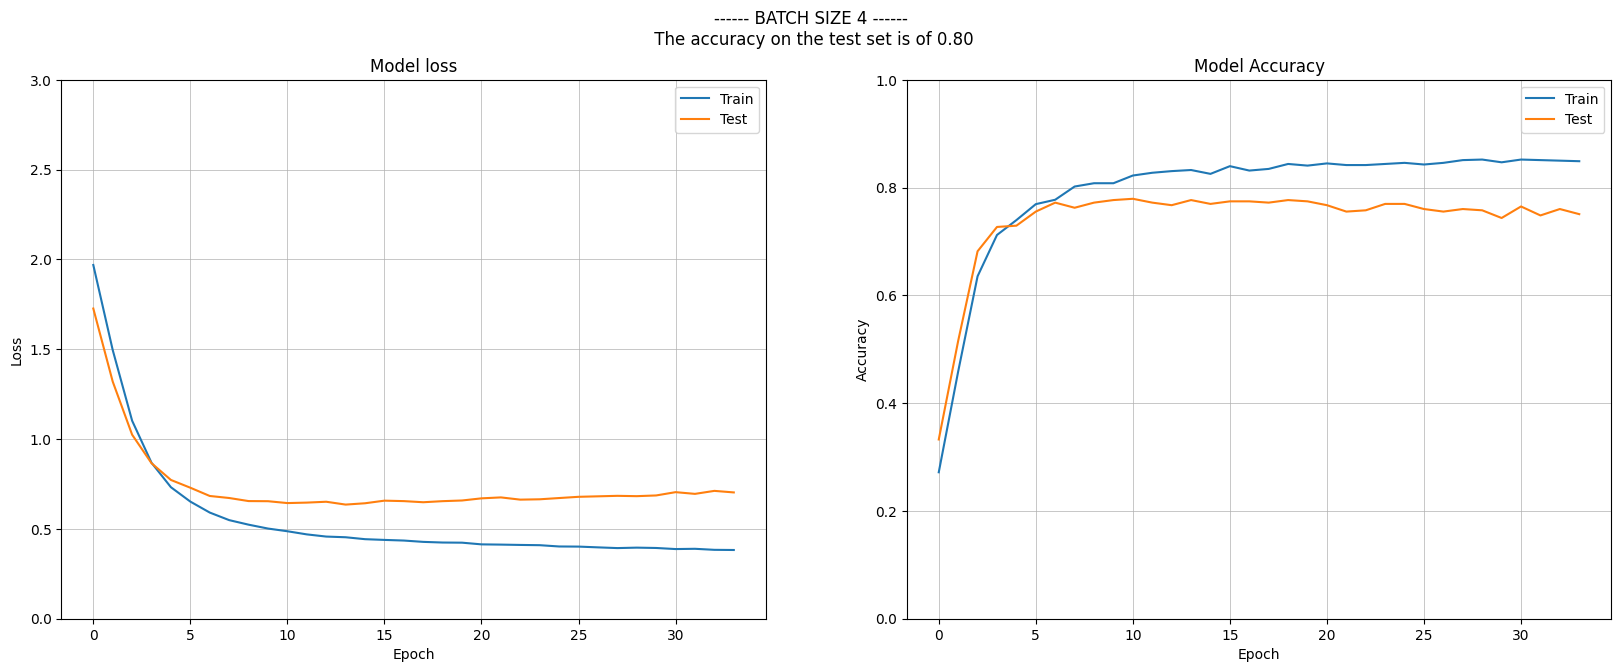

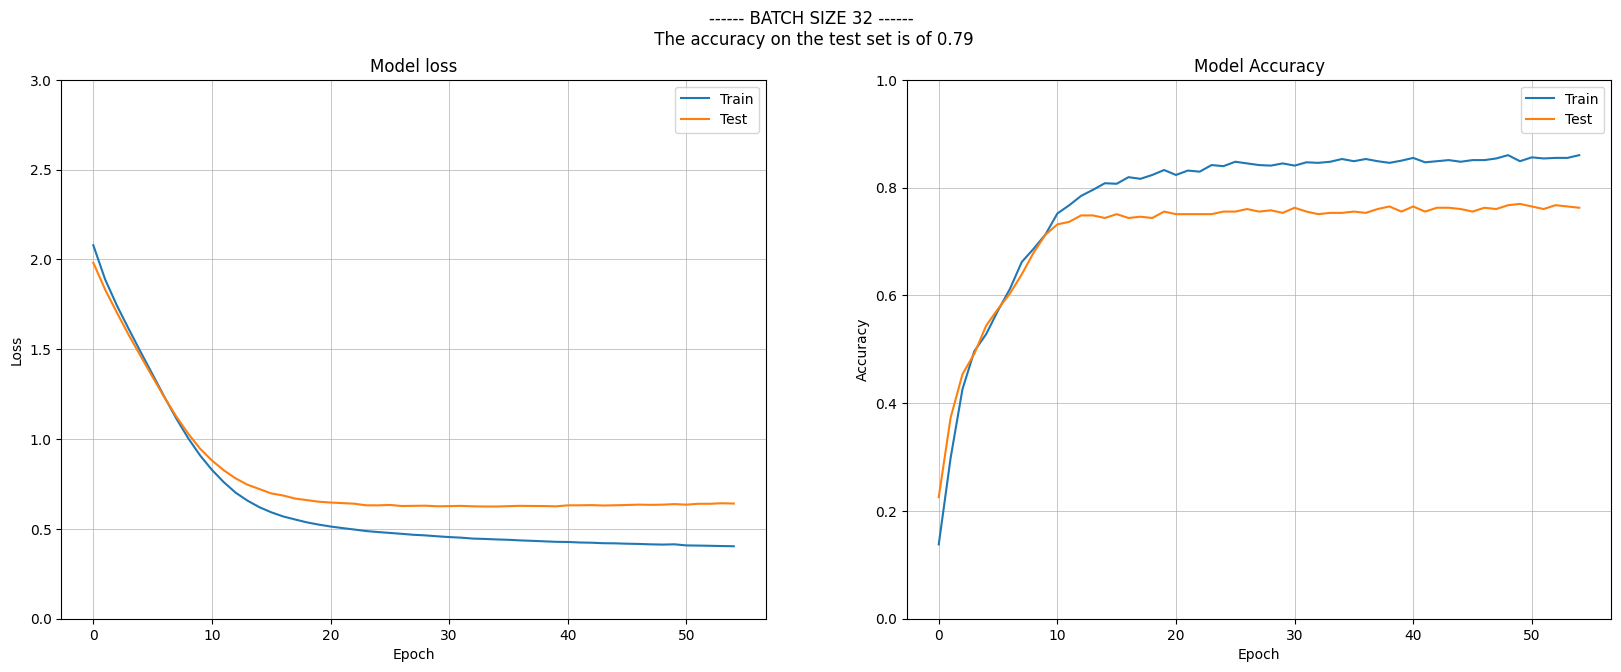

In [19]:
%%time
es = EarlyStopping(patience=20, restore_best_weights=True)
for batch_size in [1, 4, 32]:
    model = initialize_model()
    history = model.fit(
        X_train_scaled,
        y_train,
        validation_split = 0.3,
        epochs = 500,
        batch_size = batch_size, 
        verbose = 0, 
        callbacks = [es]
    )
    results = model.evaluate(X_test_scaled, y_test, verbose=0)
    plot_loss_accuracy(history, title=f'------ BATCH SIZE {batch_size} ------\n The accuracy on the test set is of {results[1]:.2f}')

#### ❓Question: Impact of the Batch Size on the Convergence of a Neural Network

Look at the oscillations of the accuracy and the loss according to the batch size number. 

Is this coherent with what we saw when playing with the TensorFlow Playground? 

> Certainly, the oscillations in accuracy and loss metrics with smaller batch sizes are coherent with what is generally observed in TensorFlow Playground

#### ❓Question: Number of Parameter Updates

How many weight optimizations are done within one epoch (considering the number of observations and the batch size)? Does one epoch have more weight updates with a large or with a small batch size?

> One epoch will have more weight updates with a smaller batch size. The number of updates is calculated as the total number of observations divided by the batch size

In [20]:
%%time
model = initialize_model()
history = model.fit(
    X_train_scaled, 
    y_train,
    validation_split = 0.3,
    epochs = 16,
    batch_size = 2, 
    verbose = 1
)

Epoch 1/16
490/490 [==============================] - 4s 4ms/step - loss: 1.6468 - accuracy: 0.3381 - val_loss: 1.3001 - val_accuracy: 0.5083
Epoch 2/16
490/490 [==============================] - 2s 3ms/step - loss: 1.0282 - accuracy: 0.6374 - val_loss: 0.9128 - val_accuracy: 0.6936
Epoch 3/16
490/490 [==============================] - 2s 3ms/step - loss: 0.7565 - accuracy: 0.7375 - val_loss: 0.7665 - val_accuracy: 0.7173
Epoch 4/16
490/490 [==============================] - 2s 3ms/step - loss: 0.6348 - accuracy: 0.7773 - val_loss: 0.6972 - val_accuracy: 0.7577
Epoch 5/16
490/490 [==============================] - 2s 3ms/step - loss: 0.5638 - accuracy: 0.7967 - val_loss: 0.6601 - val_accuracy: 0.7720
Epoch 6/16
490/490 [==============================] - 2s 3ms/step - loss: 0.5163 - accuracy: 0.8121 - val_loss: 0.6280 - val_accuracy: 0.7720
Epoch 7/16
490/490 [==============================] - 2s 3ms/step - loss: 0.4912 - accuracy: 0.8284 - val_loss: 0.6273 - val_accuracy: 0.7791
Epoch 

### (2.3) Regularization

#### Observing Overfitting Before Regularizing

The accuracy on the testing set is 0.77...
...whereas the accuracy on the training set is 0.88!
CPU times: total: 1min 59s
Wall time: 1min 17s


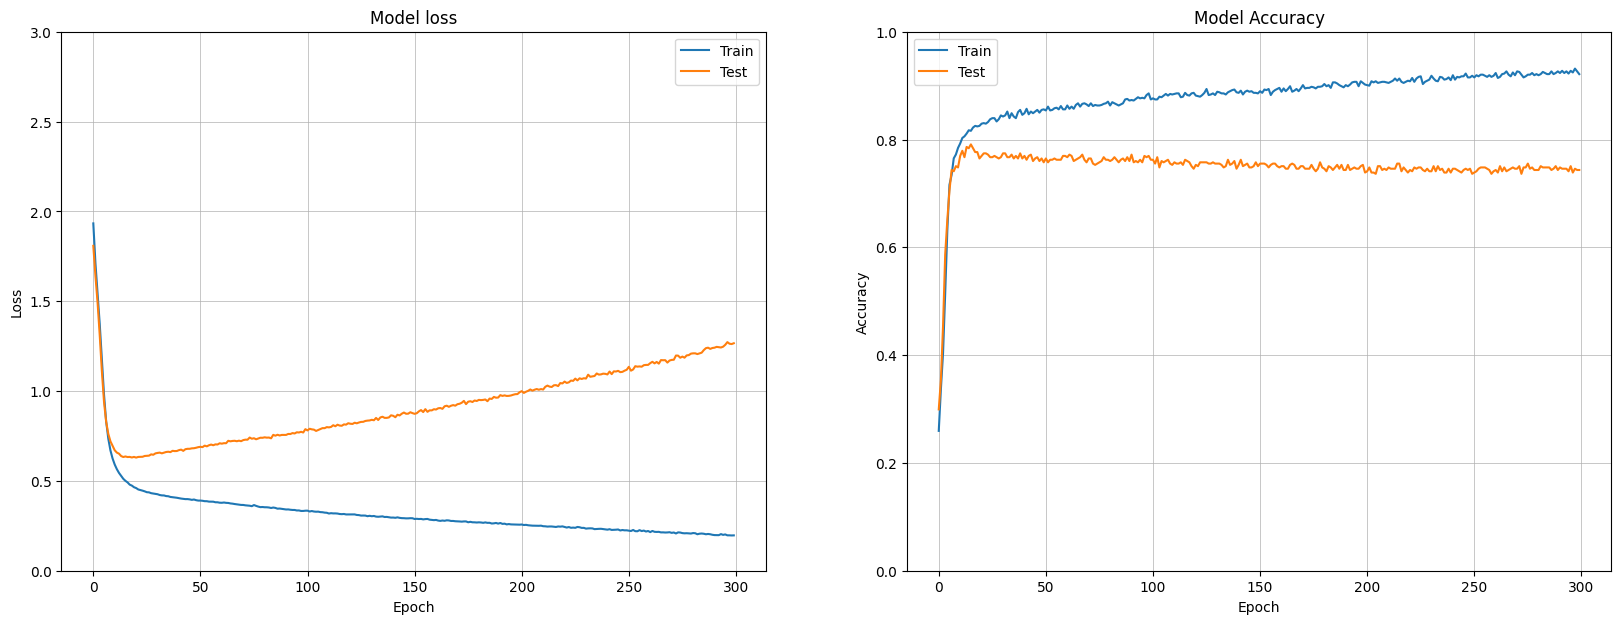

In [21]:
%%time
model = initialize_model()
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           
    batch_size = 16, 
    verbose=0
)
results_train = model.evaluate(X_train_scaled, y_train, verbose = 0)
results_test = model.evaluate(X_test_scaled, y_test, verbose = 0)
plot_loss_accuracy(history)
print(f'The accuracy on the testing set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')

#### Studying the Impact of Regularization on the Neural Network

In [22]:
reg_dict = {
    "reg_L1" : regularizers.L1(0.01),
    "reg_L2" : regularizers.L2(0.01),
    "reg_L1_L2" : regularizers.l1_l2(l1=0.005, l2=0.0005)
}

In [23]:
def reg_model(reg_L: dict):
    
    model = models.Sequential()
    model.add(layers.Dense(25, activation='relu', input_dim=10, kernel_regularizer=reg_L.get('reg_L1')))
    model.add(layers.Dense(10, activation='relu', bias_regularizer=reg_L.get('reg_L2')))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

The accuracy on the test set is 0.72...
...whereas the accuracy on the training set is 0.91!
CPU times: total: 1min 47s
Wall time: 1min 9s


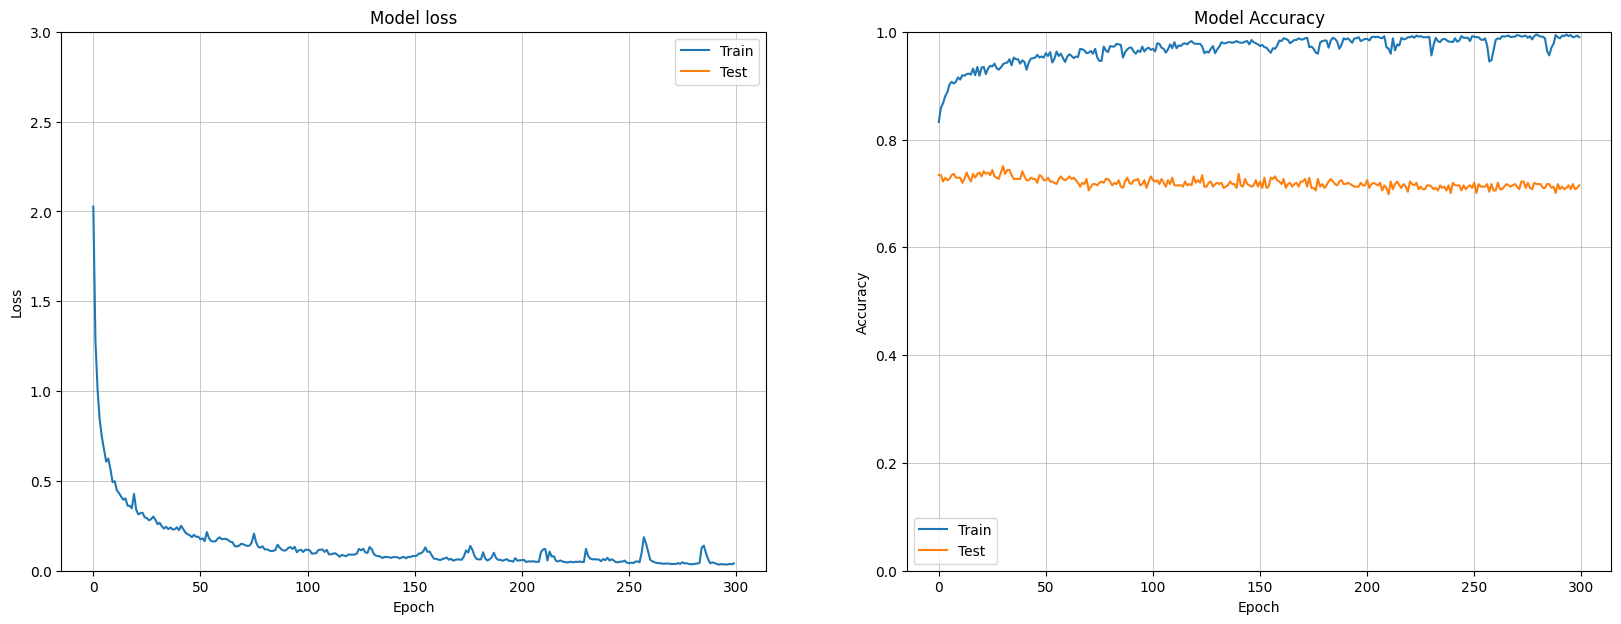

In [24]:
%%time
reg_model = reg_model(reg_dict)
history = model.fit(
    X_train, y_train,
    validation_split = 0.3,
    epochs = 300,           
    batch_size = 16, 
    verbose=0
)
results_train = model.evaluate(X_train, y_train, verbose = 0)
results_test = model.evaluate(X_test, y_test, verbose = 0)
plot_loss_accuracy(history)
print(f'The accuracy on the test set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')

### (2.4) Dropout Layers

#### Studying the Impact of Dropout Layers on the Neural Network

Include some Dropout layers in the architecture of your original model.

In [25]:
def drop_model():
    
    model = models.Sequential()
    model.add(layers.Dense(25, activation='relu', input_dim=10))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )                     
    return model

The accuracy on the test set is 0.73...
...whereas the accuracy on the training set is 0.74!
CPU times: total: 2min 3s
Wall time: 1min 16s


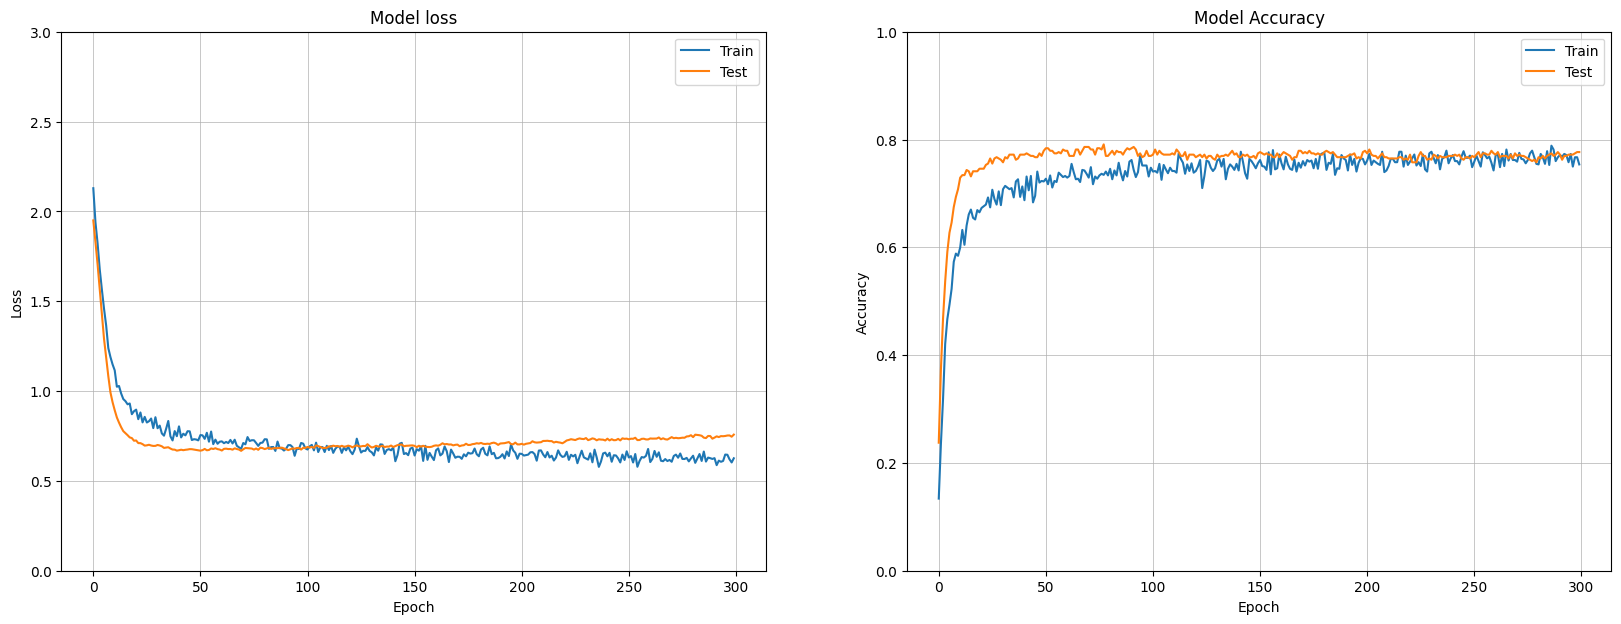

In [26]:
%%time
model = drop_model()
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           
    batch_size = 16, 
    verbose=0
)
results_train = model.evaluate(X_train, y_train, verbose = 0)
results_test = model.evaluate(X_test, y_test, verbose = 0)
plot_loss_accuracy(history)
print(f'The accuracy on the test set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')